In [ ]:

import sys
sys.path.append('/home/scuk/RS/mujoco-py')
import mujoco_py
import safety_gym
import gym
from thinker import wrapper
import cv2
import numpy as np

env = gym.make('Safexp-PointGoal1-v0')
env = wrapper.DiscretizeActionWrapper(env)
env = wrapper.RepeatActionWrapper(env, frame_stack_n=4)
env.reset()
for _ in range(100):
    state, reward, done, info = env.step([5])
    if done: 
        env.reset()
        print("Done!")

In [1]:
from thinker.main import Env
from thinker.self_play import init_env_out, create_env_out
from thinker.actor_net import ActorNet
import thinker.util as util
import os
import torch

seed = 1
xpid = "v14_se"
savedir = "/home/scuk/RS/thinker/logs/thinker/"

ckpdir = os.path.join(savedir, xpid) 
config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
env = Env(
    name=flags.name,
    env_n=1,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True)
env.seed([0])
state = env.reset()


Initializing env 0 with device cpu
Model network size: 6637133


Loaded config from /home/scuk/RS/thinker/logs/thinker/v14_se/config_c.yaml


Loaded model net from /home/scuk/RS/thinker/logs/thinker/v14_se/ckp_model.tar


Tree rep shape:  95
Tree rep meaning:  {'root_td': slice(0, 1, None), 'root_action': slice(1, 6, None), 'root_r': slice(6, 7, None), 'root_v': slice(7, 8, None), 'root_logits': slice(8, 13, None), 'cur_td': slice(13, 14, None), 'cur_action': slice(14, 19, None), 'cur_r': slice(19, 20, None), 'cur_v': slice(20, 21, None), 'cur_logits': slice(21, 26, None), 'cur_reset': slice(26, 27, None), 'one_hot_k': slice(27, 37, None), 'rollout_return': slice(37, 38, None), 'max_rollout_return': slice(38, 39, None), 'rollout_done': slice(39, 40, None), 'root_action_table': slice(40, 65, None), 'root_td_table': slice(65, 70, None), 'action_seq': slice(70, 95, None)}


In [2]:
xpid = "v14_se_baseline"
ckpdir = os.path.join(savedir, xpid) 
config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
env_ = Env(
    name=flags.name,
    env_n=1,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True,
    tree_carry=False,
    )
env_.model_net = env.model_net
env_.seed([0])
state_ = env_.reset()


Initializing env 0 with device cpu
Model network size: 6637133
Loaded model net from /home/scuk/RS/thinker/logs/thinker/v14_se_baseline/ckp_model.tar


Loaded config from /home/scuk/RS/thinker/logs/thinker/v14_se_baseline/config_c.yaml


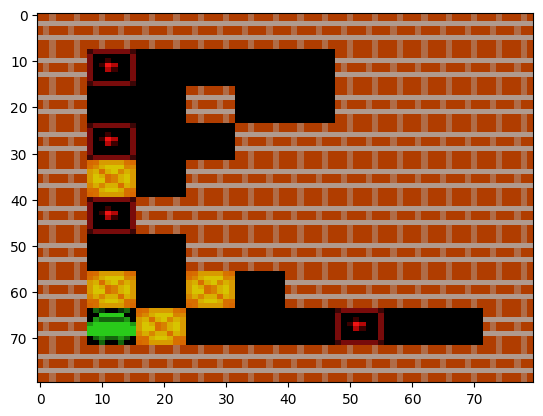

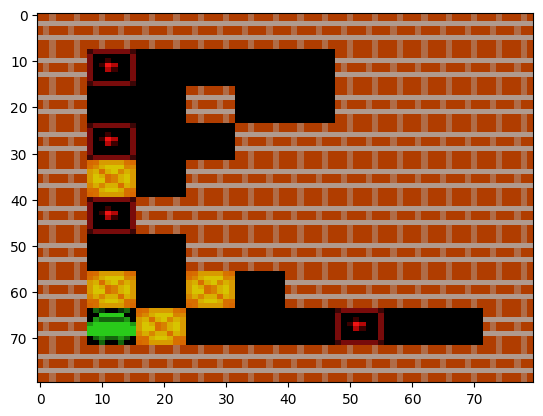

In [7]:
util.plot_raw_state(state['xs'][0])
util.plot_raw_state(state_['xs'][0])

In [9]:
np.repeat([1, 2, 3], 4)

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

========================= STEP 0 =========================
new  root_td tensor([[1.4979]])
new  root_action tensor([[1., 0., 0., 0., 0.]])
bas  root_action tensor([[1., 0., 0., 0., 0.]])
new  root_r tensor([[0.]])
bas  root_r tensor([[0.]])
new  root_v tensor([[2.8637]])
bas  root_v tensor([[2.8637]])
new  root_logits tensor([[-5.0526,  2.8640, -2.1016, -0.4181, -0.8158]])
bas  root_logits tensor([[-5.0526,  2.8640, -2.1016, -0.4181, -0.8158]])
new  cur_td tensor([[-0.1169]])
new  cur_action tensor([[0., 0., 0., 0., 1.]])
bas  cur_action tensor([[0., 0., 0., 0., 1.]])
new  cur_r tensor([[-0.0050]])
bas  cur_r tensor([[-0.0050]])
new  cur_v tensor([[2.8370]])
bas  cur_v tensor([[2.8370]])
new  cur_logits tensor([[-6.5008,  0.2744, -0.2436, -1.0412,  2.6593]])
bas  cur_logits tensor([[-6.5008,  0.2744, -0.2436, -1.0412,  2.6593]])
new  cur_reset tensor([[0.]])
bas  cur_reset tensor([[0.]])
new  one_hot_k tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
new  rollout_return tensor([[2.74

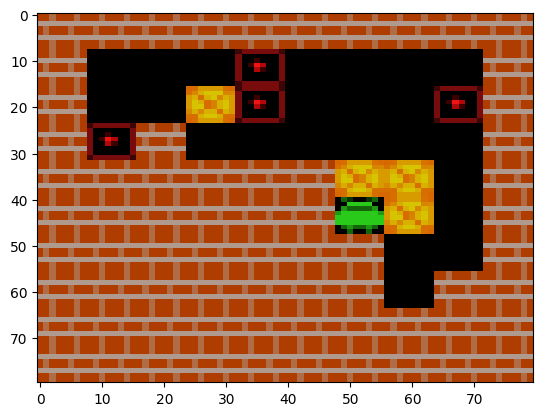

In [3]:
import numpy as np

def ckp_diff(x, y, name):
    assert torch.sum(torch.square(x.float()-y.float())) < 1e-8, \
            f"error for {name}, value new: {x}, value bas: {y}"

pri = [np.random.randint(5) for _ in range(2000)]
res = [np.random.randint(2) for _ in range(2000)]

pri = [2]
res = [1]

pri = [4, 4, 4, 4, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 4, 2, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 1, 3, 3, 2, 3, 1, 1, 0, 0, 0, 0, 0, 2]
pri = np.repeat(pri, env.rep_rec_t)
res = np.zeros_like(pri)

print_txt = True
r_done = False
for m, (a, r) in enumerate(zip(pri, res)):
    state, reward, done, info = env.step(torch.tensor([a]), torch.tensor([r]))
    state_, reward_, done_, info_ = env_.step(torch.tensor([a]), torch.tensor([r]))
    real_step = info["step_status"][0] == 0
    if real_step: r_done = done
    if info["baseline"] is not None: print("baseline: ", info["baseline"], info_["baseline"])
    tr = env.decode_tree_reps(state['tree_reps'])
    tr_ = env_.decode_tree_reps(state_['tree_reps'])

    if m > 0: ckp_diff(info["im_reward"], info_["im_reward"], "im_reward")        
    if real_step: ckp_diff(state["real_states"], state_["real_states"], "real_states")        
    ckp_diff(reward, reward_, "reward")        
    ckp_diff(info["truncated_done"], info_["truncated_done"], "truncated_done")        
    ckp_diff(info["real_done"], info_["real_done"], "real_done")        

    #util.plot_raw_state(state['xs'][0])
    #util.plot_raw_state(state_['xs'][0])
    print(f"========================= STEP {m} =========================")
    for k, v in tr.items():
        if print_txt: print("new ", k, v)
        if k in tr_:
            if print_txt: print("bas ", k, tr_[k])
            if k == "action_seq": 
                v_ = tr_[k][:, env.num_actions:]
            else:
                v_ = tr_[k]
            if k == "cur_reset": continue
            if r_done and k in ["root_r", "cur_r"]: continue
            assert torch.sum(torch.square(v_-v)) < 1e-8, f"error for {k}, value new: {v}, value bas: {v_}"

    for k, v in tr_.items():
        if k not in tr:
            if print_txt: print("bas ", k, tr_[k])
util.plot_raw_state(state['xs'][0])

In [25]:
env.rollout_done

tensor([True])

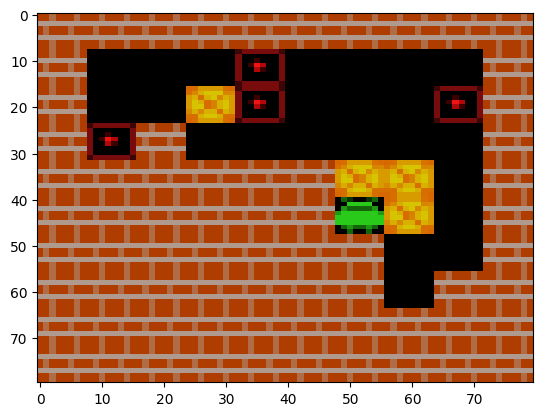

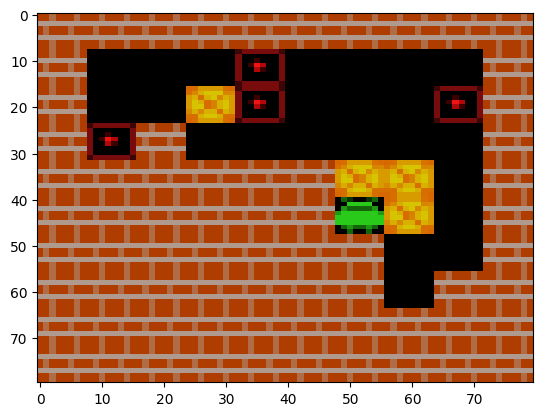

In [4]:
util.plot_raw_state(state['xs'][0])
util.plot_raw_state(state_['xs'][0])

In [3]:
tr["cur_r"] + env.discounting * tr["cur_v"] - tr["root_v"]

tensor([[0.0130]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bas  root_td tensor([[1.4979]])
bas  root_action tensor([[1., 0., 0., 0., 0.]])
bas  root_r tensor([[0.]])
bas  root_v tensor([[2.8637]])
bas  root_logits tensor([[-5.0526,  2.8640, -2.1016, -0.4181, -0.8158]])
bas  cur_td tensor([[0.1771]])
bas  cur_action tensor([[0., 1., 0., 0., 0.]])
bas  cur_r tensor([[-0.0064]])
bas  cur_v tensor([[3.1415]])
bas  cur_logits tensor([[-6.3967,  2.9218, -2.2988,  0.5404, -1.5741]])
bas  cur_reset tensor([[1.]])
bas  one_hot_k tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
bas  rollout_return tensor([[3.0408]])
bas  max_rollout_return tensor([[3.0408]])
bas  rollout_done tensor([[0.]])
bas  root_action_table tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])
bas  root_td_table tensor([[0.1718, 0.0000, 0.0000, 0.0000, 0.0000]])
bas  action_seq tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])


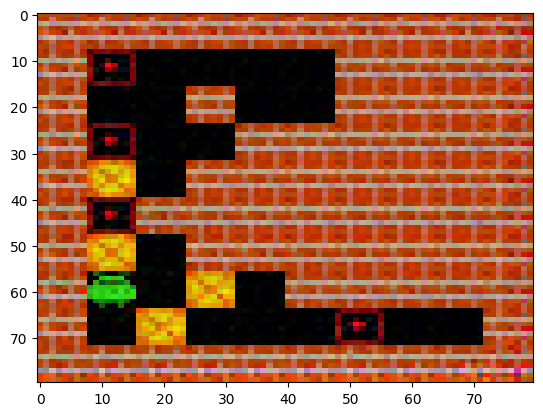

In [5]:
import numpy as np
pri = [2]
pri = [np.random.randint(5)]
res = [1]
res = [np.random.randint(2)]

for a, r in zip(pri, res):
    state, reward, done, info = env.step(torch.tensor([a]), torch.tensor([r]))
    if info["baseline"] is not None: print("baseline: ", info["baseline"], info_["baseline"])
    tr = env.decode_tree_reps(state['tree_reps'])    

    util.plot_raw_state(state['xs'][0])
    for k, v in tr.items():
        print("bas ", k, tr[k])




In [15]:
-0.0086 + 0.97 * -0.0035 + 0.97 ** 2 * -0.1486

-0.15181274

In [10]:
tr["cur_r"]

IndexError: too many indices for tensor of dimension 2

3


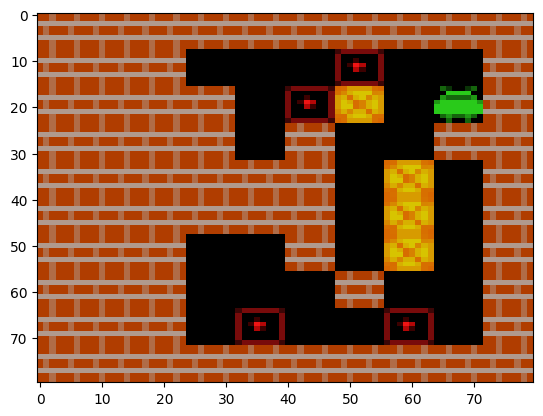

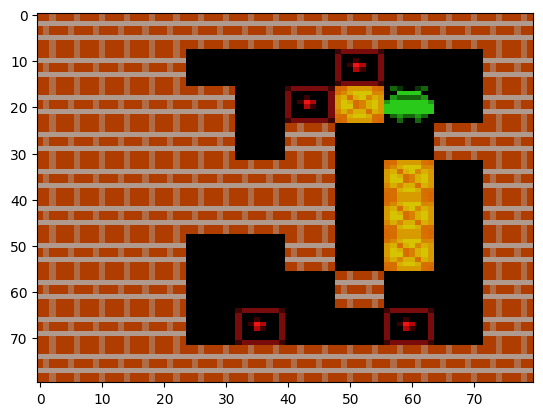

In [37]:
b = 3
t = -2

s_t = d['real_state'][t, b]
a_t = d['action'][t + 1, b]
s_t1 = d['real_state'][t + 1, b]

util.plot_raw_state(torch.tensor(s_t))
util.plot_raw_state(torch.tensor(s_t1))
print(a_t)